May 5: Constructing IDEALIZED, the bathymetry of an idealized canyon with the dimensions of Mackenzie canyon that will be used to test NEMO's performance at these scales.

The shape of the continental shelf containing the canyon is defined as
$$H_0(x,y) = H_D - \frac{1}{2} \big(H_D - H_S \big) \Bigg[ 1 - tanh \Big( \frac{y-y_0(x)}{y_c} \Big) \Bigg]$$

$H_D$ = maximum depth in domain

$H_S$ = shelf depth

$y_c$ = steepness of the continental slope

$$y_0(x) = \big( y_n + y_b \big) \Bigg[ 1-e^{\frac{-(x^2 - x_0^2)}{2b^2}} \Bigg]$$

$y_n$ = distance between head and coast

$y_b$ = distance between head and shelf break

$x_0$ = location of axis

$b$ = canyon width

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
%matplotlib inline

In [2]:
HD = 600
HS = 80
yc_w = 0.0021568134301886434
yc_e = 0.0018626783964848554
yn = 62.92 * 1000
yb = 91.92 * 1000
b = 151.6 * 1000
x0 = 100000

In [3]:
HD = HD/1000; HS = HS/1000; yn = yn/1000; yb = yb/1000; b = b/1000; x0 = x0/1000

In [4]:
x = np.arange(0, 200, dtype=np.float)
y = np.arange(0, 200, dtype=np.float)
y0 = np.zeros((len(y),len(x)))
H0 = np.zeros((len(y),len(x)))
yc = yc_w

In [5]:
for j in range(len(y)):
    for i in range(len(x)):
        y0[j,i] = (yn+yb)*(1-np.exp((-1*(x[i]**2-x0**2))/(2*(b**2))))
        H0[j,i] = HD-0.5*(HD-HS)*(1-np.tanh((y[j]-y0[j,i])/yc))

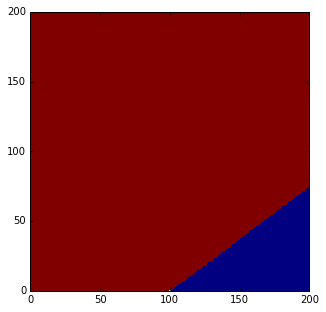

In [6]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.pcolormesh(H0)

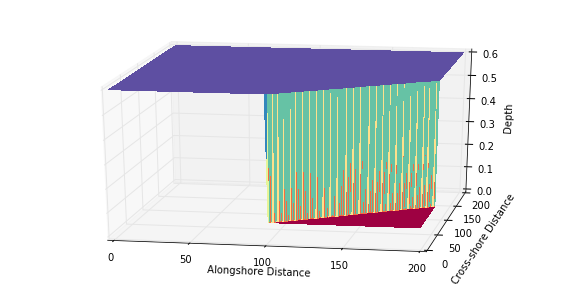

In [10]:
fig = plt.figure(figsize=(10,5))
ax = fig.gca(projection='3d')
X, Y = np.meshgrid(x, y)
surf = ax.plot_surface(X, Y, H0, cmap=cm.Spectral, linewidth=0, rstride=1, cstride=1, antialiased=False)
ax.view_init(elev=20, azim=-80)
ax.set_xlabel('Alongshore Distance')
ax.set_ylabel('Cross-shore Distance')
ax.set_zlabel('Depth')